# dislocation_SDVPN calculation style

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

## Introduction

The dislocation_SDVPN calculation style predicts a dislocation's planar spreading using the semidiscrete variational Peierls-Nabarro method.  The solution finds the disregistry (difference in displacement above and below the slip plane) that minimizes the dislocation's energy.  The energy term consists of two primary components: an elastic component due to the dislocation interacting with itself, and a misfit component arising from the formation of a generalized stacking fault along the dislocation's spreading.

### Version notes

- 2018-09-25: Notebook added
- 2019-07-30: Notebook setup and parameters changed.
- 2020-09-22: Notebook updated to reflect changes in the calculation method due to updates in atomman's Volterra class solution generators.  Setup and parameter definitiions streamlined.

### Additional dependencies

### Disclaimers

- [NIST disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)
- The calculation method solves the problem using a 2D generalized stacking fault energy map.  Better results may be possible by measuring a full 3D map, but that would require adding a new calculation for the 3D variation.
- The implemented method is suited for dislocations with planar spreading. It is not suited for dislocations that spread on multiple atomic planes, like the a/2<111> bcc screw dislocation.
- While the solution is taken at discrete points that (typically) correspond to atomic sites, the underlying method is still a continuum solution that does not fully account for the atomic nature of the dislocation.


## Method and Theory

This calculation method is a wrapper around the atomman.defect.SDVPN class.  More details on the method and theory can be found in the [associated tutorial within the atomman documentation](https://www.ctcms.nist.gov/potentials/atomman/tutorial/04.4._Semidiscrete_Variational_Peierls-Nabarro.html).


## Demonstration

### 1. Setup

#### 1.1. Library imports

Import libraries needed by the calculation. The external libraries used are:

- [numpy](http://www.numpy.org/)

- [scipy](https://scipy.org/scipylib/)

- [matplotlib](https://matplotlib.org/)

- [atomman](https://github.com/usnistgov/atomman)

- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from pathlib import Path
import os
import datetime
from copy import deepcopy

# http://www.numpy.org/
import numpy as np 

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

print('Notebook last executed on', datetime.date.today(), 'using iprPy version', iprPy.__version__)

Notebook last executed on 2021-03-08 using iprPy version 0.10.4


#### 1.2. Default calculation setup

In [2]:
# Specify calculation style
calc_style = 'dislocation_SDVPN'

# If workingdir is already set, then do nothing (already in correct folder)
try:
    workingdir = workingdir

# Change to workingdir if not already there
except:
    workingdir = Path('calculationfiles', calc_style)
    if not workingdir.is_dir():
        workingdir.mkdir(parents=True)
    os.chdir(workingdir)
    
# Initialize connection to library
library = iprPy.Library(load=['lammps_potentials'])

### 2. Assign values for the calculation's run parameters

#### 2.1. Load initial unit cell system

- __ucell__ is an atomman.System representing a fundamental unit cell of the system (required).  Here, this is loaded from the database for the prototype.

In [3]:
# Create ucell by loading prototype record
ucell = am.load('crystal', potential_LAMMPS_id='1999--Mishin-Y--Ni--LAMMPS--ipr1', family='A1--Cu--fcc', database=library)

print(ucell)

avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Ni',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


#### 2.2 Specify material elastic constants

Simple input parameters:

- __C_dict__ is a dictionary containing the unique elastic constants for the potential and crystal structure defined above. 

Derived parameters

- __C__ is an atomman.ElasticConstants object built from C_dict.

In [4]:
C_dict = {}
C_dict['C11'] = uc.set_in_units(247.86, 'GPa')
C_dict['C12'] = uc.set_in_units(147.83, 'GPa')
C_dict['C44'] = uc.set_in_units(124.84, 'GPa')

# -------------- Derived parameters -------------- #
# Build ElasticConstants object from C_dict terms
C = am.ElasticConstants(**C_dict)

#### 2.3 Specify the defect parameters

- __gammasurface_file__ gives the path to a data model file containing 2D gamma surface results.  This can be a calc_stacking_fault_map_2D record.

- __burgers__ is the crystallographic Miller Burgers vector for the dislocation. 

- __ξ_uvw__ is the Miller \[uvw\] line vector direction for the dislocation.  The angle between burgers and ξ_uvw determines the dislocation's character

- __slip_hkl__ is the Miller (hkl) slip plane for the dislocation.
    
- __m__ is the Cartesian vector of the final system that the dislocation solution's m vector (in-plane, perpendicular to ξ) should align with.  Limited to being parallel to one of the three Cartesian axes.  

- __n__ is the Cartesian vector of the final system that the dislocation solution's n vector (slip plane normal) should align with.  Limited to being parallel to one of the three Cartesian axes. 

- __gamma__ is a GammaSurface object.  Here, it is loaded from gammasurface_file.  Note that gamma and volterra must be for the same plane.

- __volterra__ is a VolterraDislocation object for the dislocation type of interest.  Here, it is created based on the elastic constants, unit cell and dislocation parameters above.  Note that gamma and volterra must be for the same plane. 

In [5]:
gammasurface_file = '../stacking_fault_map_2D/gamma.json'
gamma = am.defect.GammaSurface(model=gammasurface_file)

# fcc a/2 <110>{111} dislocations
burgers = 0.5 * np.array([ 1., -1., 0.])
slip_hkl = [1, 1, 1]

# Line direction determines dislocation character
ξ_uvw = [ 1, 1,-2] # 90 degree edge
#ξ_uvw = [ 1, 0,-1] # 60 degree mixed
#ξ_uvw = [ 1,-2, 1] # 30 degree mixed
#ξ_uvw = [ 1,-1, 0] # 0 degree screw

# Best choice for m + n as it works for non-cubic systems
m = [0,1,0]
n = [0,0,1]

#### 2.4 Specify calculation-specific run parameters

- __xmax__: The maximum value of the x-coordinates to use for the points where the disregistry is evaluated.  The solution is centered around x=0, therefore this also corresponds to the minimum value of x used.  The set of x-coordinates used is fully defined by giving at least two of xmax, xstep and xnum.

- __xstep__: The step size (delta x) value between the x-coordinates used to evaluate the disregistry.  The set of x-coordinates used is fully defined by giving at least two of xmax, xstep and xnum.

- __xnum__: The total number of x-coordinates at which to evaluate the disregistry.  The set of x-coordinates used is fully defined by giving at least two of xmax, xstep and xnum.

- __min_method__: The scipy.optimize.minimize method style to use when solving for the disregistry.  Default value is 'Powell', which seems to do decently well for this problem.

- __min_options__: Allows for the specification of the options dictionary used by scipy.optimize.minimize. This is given as "key value key value...".

- __min_cycles__: Specifies the number of times to run the minimization in succession.  The minimization algorithms used by the underlying scipy code often benefit from restarting and rerunning the minimized configuration to achive a better fit.  Default value is 10.

- __cutofflongrange__: The radial cutoff (in distance units) to use for the long-range elastic energy.  The long-range elastic energy is configuration-independent, so this value changes the dislocation's energy but not the computed disregistry profile. Default value is 1000 Angstroms.

- __tau_xy__: Shear stress (in units of pressure) to apply to the system. Default value is 0 GPa.

- __tau_yy__: Normal stress (in units of pressure) to apply to the system. Default value is 0 GPa.

- __tau_yz__: Shear stress (in units of pressure) to apply to the system. Default value is 0 GPa.

- __alpha__: Coefficient(s) (in pressure/length units) of the non-local energy correction term to use.  Default value is 0.0, meaning this correction is not applied.

- __beta_xx, beta_yy, beta_zz, beta_xy, beta_xz, beta_yz__: Components of the surface energy coefficient tensor (in units pressure-length) to use. Default value is 0.0 GPa-Angstrom for all, meaning this correction is not applied.

- __cdiffelastic, cdiffsurface, cdiffstress__: Booleans indicating how the dislocation density (derivative of disregistry) is computed within the elastic, surface and stress terms, respectively. If True, central difference is used, otherwise only the change between the current and previous points is used. Default values are True for cdiffsurface, and False for the other two.

- __halfwidth__: The arctan disregistry halfwidth (in length units) to use for creating the initial disregistry guess.

- __normalizedisreg__: Boolean indicating how the disregistry profile is handled.  If True (default), the disregistry is scaled such that the minimum x value has a disregistry of 0 and the maximum x value has a disregistry equal to the dislocation's Burgers vector.  Note that the disregistry for these endpoints is fixed, so if you use False the initial disregistry should be close to the final solution.

- __fullstress__: Boolean indicating which of two stress formulas to use.  True uses the original full formulation, while False uses a newer, simpler representation.  Default value is True.

In [6]:
xmax = None
xstep = 1/5
xnum = 200
xscale = True

min_method = 'Powell'
min_options = {}
min_options['disp'] = True # will display convergence info
min_options['xtol'] = 1e-6 # smaller convergence tolerance than default
min_options['ftol'] = 1e-6 # smaller convergence tolerance than default
#min_options['maxiter'] = 2 # for testing purposes
min_cycles = 10

cutofflongrange = uc.set_in_units(1000, 'angstrom')
halfwidth = uc.set_in_units(5, 'angstrom')

### 3. Define calculation function(s)

#### 3.1. peierlsnabarro()

In [7]:
def peierlsnabarro(ucell, C, burgers, ξ_uvw, slip_hkl, gamma,
                   m=[0,1,0], n=[0,0,1],
                   cutofflongrange=uc.set_in_units(1000, 'angstrom'),
                   tau=np.zeros((3,3)), alpha=[0.0], beta=np.zeros((3,3)),
                   cdiffelastic=False, cdiffsurface=True, cdiffstress=False,
                   fullstress=True,
                   halfwidth=uc.set_in_units(1, 'angstrom'),
                   normalizedisreg=True,
                   xnum=None, xmax=None, xstep=None, xscale=False,
                   min_method='Powell', min_options={}, min_cycles=10):
    """
    Solves a Peierls-Nabarro dislocation model.

    Parameters
    ----------
    ucell : atomman.System
        The unit cell to use as the seed for the dislocation system.  Note that
        only box information is used and not atomic positions.
    C : atomman.ElasticConstants
        The elastic constants associated with the bulk crystal structure
        for ucell.
    burgers : array-like object
        The dislocation's Burgers vector given as a Miller or
        Miller-Bravais vector relative to ucell.
    ξ_uvw : array-like object
        The dislocation's line direction given as a Miller or
        Miller-Bravais vector relative to ucell.
    slip_hkl : array-like object
        The dislocation's slip plane given as a Miller or Miller-Bravais
        plane relative to ucell.
    m : array-like object, optional
        The m unit vector for the dislocation solution.  m, n, and ξ
        (dislocation line) should be right-hand orthogonal.  Default value
        is [0,1,0] (y-axis).
    n : array-like object, optional
        The n unit vector for the dislocation solution.  m, n, and ξ
        (dislocation line) should be right-hand orthogonal.  Default value
        is [0,0,1] (z-axis). n is normal to the dislocation slip plane.
    cutofflongrange : float, optional
        The cutoff distance to use for computing the long-range energy.
        Default value is 1000 angstroms.
    tau : numpy.ndarray, optional
        A (3,3) array giving the stress tensor to apply to the system
        using the stress energy term.  Only the xy, yy, and yz components
        are used.  Default value is all zeros.
    alpha : list of float, optional
        The alpha coefficient(s) used by the nonlocal energy term.  Default
        value is [0.0].
    beta : numpy.ndarray, optional
        The (3,3) array of beta coefficient(s) used by the surface energy
        term.  Default value is all zeros.
    cdiffelastic : bool, optional
        Flag indicating if the dislocation density for the elastic energy
        component is computed with central difference (True) or simply
        neighboring values (False).  Default value is False.
    cdiffsurface : bool, optional
        Flag indicating if the dislocation density for the surface energy
        component is computed with central difference (True) or simply
        neighboring values (False).  Default value is True.
    cdiffstress : bool, optional
        Flag indicating if the dislocation density for the stress energy
        component is computed with central difference (True) or simply
        neighboring values (False).  Only matters if fullstress is True.
        Default value is False.
    fullstress : bool, optional
        Flag indicating which stress energy algorithm to use.  Default
        value is True.
    halfwidth : float, optional
        A dislocation halfwidth guess to use for generating the initial
        disregistry guess.  Does not have to be accurate, but the better the
        guess the fewer minimization steps will likely be needed.  Default
        value is 1 Angstrom.
    normalizedisreg : bool, optional
        If True, the initial disregistry guess will be scaled such that it
        will have a value of 0 at the minimum x and a value of burgers at the
        maximum x.  Default value is True.  Note: the disregistry of end points
        are fixed, thus True is usually preferential.
    xnum :  int, optional
        The number of x value points to use for the solution.  Two of xnum,
        xmax, and xstep must be given.
    xmax : float, optional
        The maximum value of x to use.  Note that the minimum x value will be
        -xmax, thus the range of x will be twice xmax.  Two of xnum, xmax, and
        xstep must be given.
    xstep : float, optional
        The delta x value to use, i.e. the step size between the x values used.
        Two of xnum, xmax, and xstep must be given.
    xscale : bool, optional
        Flag indicating if xmax and/or xstep values are to be taken as absolute
        or relative to ucell's a lattice parameter.  Default value is False,
        i.e. the x parameters are absolute and not scaled.
    min_method : str, optional
        The scipy.optimize.minimize method to use.  Default value is
        'Powell'.
    min_options : dict, optional
        Any options to pass on to scipy.optimize.minimize. Default value
        is {}.
    min_cycles : int, optional
        The number of minimization runs to perform on the system.  Restarting
        after obtaining a solution can help further refine to the best pathway.
        Default value is 10. 
    """

    # Solve Volterra dislocation
    volterra = am.defect.solve_volterra_dislocation(C, burgers, ξ_uvw=ξ_uvw,
                                                    slip_hkl=slip_hkl, box=ucell.box,
                                                    m=m, n=n)
    
    # Generate SDVPN object
    pnsolution = am.defect.SDVPN(volterra=volterra, gamma=gamma,
                                 tau=tau, alpha=alpha, beta=beta,
                                 cutofflongrange=cutofflongrange,
                                 fullstress=fullstress, cdiffelastic=cdiffelastic,
                                 cdiffsurface=cdiffsurface, cdiffstress=cdiffstress,
                                 min_method=min_method, min_options=min_options)

    # Scale xmax and xstep by alat
    if xscale is True:
        if xmax is not None:
            xmax *= ucell.box.a
        if xstep is not None:
            xstep *= ucell.box.a
    
    # Generate initial disregistry guess
    x, idisreg = am.defect.pn_arctan_disregistry(xmax=xmax, xstep=xstep, xnum=xnum,
                                                 burgers=pnsolution.burgers,
                                                 halfwidth=halfwidth,
                                                 normalize=normalizedisreg)
    
    # Set up loop parameters
    cycle = 0
    disregistries = [idisreg]
    minimization_energies = [pnsolution.total_energy(x, idisreg)]
    
    # Run minimization for min_cycles
    pnsolution.x = x
    pnsolution.disregistry = idisreg
    while cycle < min_cycles:
        cycle += 1
        pnsolution.solve()
        disregistries.append(pnsolution.disregistry)
        minimization_energies.append(pnsolution.total_energy())

    # Initialize results dict
    results_dict = {}
    results_dict['SDVPN_solution'] = pnsolution
    results_dict['minimization_energies'] = minimization_energies
    results_dict['disregistry_profiles'] = disregistries
    
    return results_dict

### 4. Run calculation function(s)

In [8]:
results_dict = peierlsnabarro(ucell, C, burgers, ξ_uvw, slip_hkl, gamma,
                              m = m,
                              n = n,
                              cutofflongrange = cutofflongrange,
                              #tau = tau,    
                              #alpha = alpha,
                              #beta = beta,
                              #cdiffelastic = cdiffelastic,
                              #cdiffsurface = cdiffsurface,
                              #cdiffstress = cdiffstress,
                              #fullstress = fullstress,
                              halfwidth = halfwidth,
                              #normalizedisreg = normalizedisreg,
                              xnum = xnum,
                              xstep = xstep,
                              xmax = xmax,
                              xscale = xscale,
                              min_method = min_method,
                              min_options = min_options,
                              min_cycles = min_cycles)

Optimization terminated successfully.
         Current function value: 4.905269
         Iterations: 25
         Function evaluations: 169106
Optimization terminated successfully.
         Current function value: 4.905263
         Iterations: 2
         Function evaluations: 16780
Optimization terminated successfully.
         Current function value: 4.905263
         Iterations: 1
         Function evaluations: 8565
Optimization terminated successfully.
         Current function value: 4.905263
         Iterations: 1
         Function evaluations: 8620
Optimization terminated successfully.
         Current function value: 4.905263
         Iterations: 1
         Function evaluations: 8937
Optimization terminated successfully.
         Current function value: 4.905263
         Iterations: 1
         Function evaluations: 9090
Optimization terminated successfully.
         Current function value: 4.905263
         Iterations: 1
         Function evaluations: 8976
Optimization terminated

In [9]:
results_dict.keys()

dict_keys(['SDVPN_solution', 'minimization_energies', 'disregistry_profiles'])

### 5. Report results

#### 5.1 Define units for outputting values

- __length_unit__ is the unit of length to display results in.
- __energy_per_length_unit__ is the unit of energy per length to display dislocation energies in.

In [10]:
length_unit = 'Å'
energyperlength_unit = 'eV/Å'
energyperarea_unit = 'eV/Å^2'

#### 5.2 Solution

SDVPN_solution in the results dictionary is an am.Defect.SDVPN object which contains the final disregistry information.

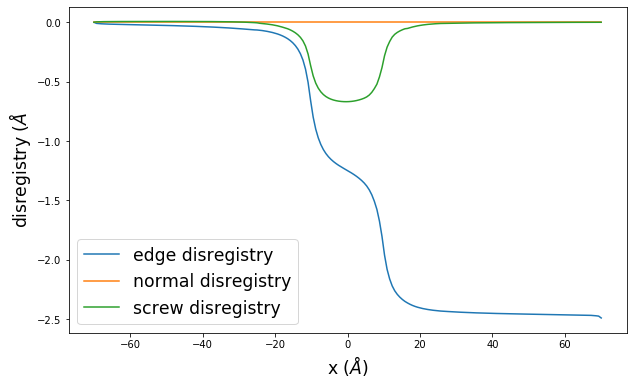

In [11]:
results_dict['SDVPN_solution'].disregistry_plot(length_unit=length_unit)
plt.show()

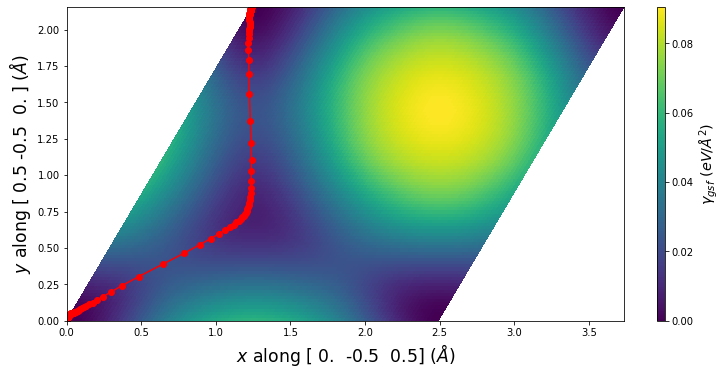

In [12]:
results_dict['SDVPN_solution'].E_gsf_surface_plot(length_unit=length_unit, energyperarea_unit=energyperarea_unit)
plt.show()

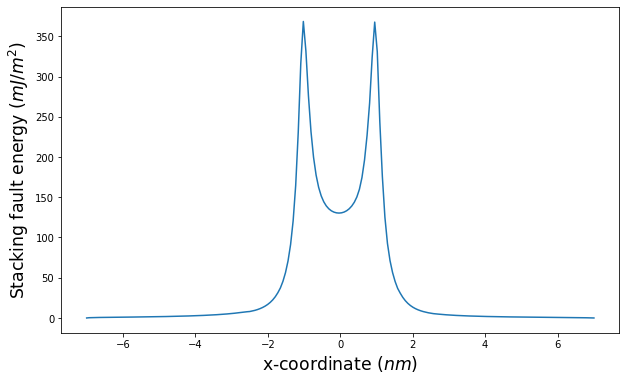

In [13]:
results_dict['SDVPN_solution'].E_gsf_vs_x_plot(length_unit='nm', energyperarea_unit='mJ/m^2')
plt.show()

#### 5.3 Minimum energy per cycle

minimization_energies in the results dict lists the total computed dislocation energy for the initial disregistry and after each minimization run.

In [14]:
print('Total dislocation energy per minimization run (in %s):' % energyperlength_unit)
for i, E_total in enumerate(results_dict['minimization_energies']):
    print(i, uc.get_in_units(E_total, energyperlength_unit))

Total dislocation energy per minimization run (in eV/Å):
0 5.344452611702983
1 4.905268833362016
2 4.9052634300504
3 4.905263286909917
4 4.9052631909361715
5 4.905263105877672
6 4.90526302164228
7 4.905262935537678
8 4.905262847023954
9 4.905262756092103
10 4.905262662820067


### 6. Save/load results

The full SDVPN results can be extracted and saved to either a JSON or XML file using the model() method of the SDVPN solution class.  This content can then be loaded into an SDVPN for future analysis or further runs.

NOTE: The model saves all input parameters so the calculation can be restarted from any point. However, it only saves the current disregistry and not any previous disregistries before minimizations. 

In [15]:
# Build the model
model = results_dict['SDVPN_solution'].model(include_gamma=True)

# Save as json
with open('sdvpn_run.json', 'w', encoding='UTF-8') as f:
    model.json(fp=f, indent=4, ensure_ascii=False)

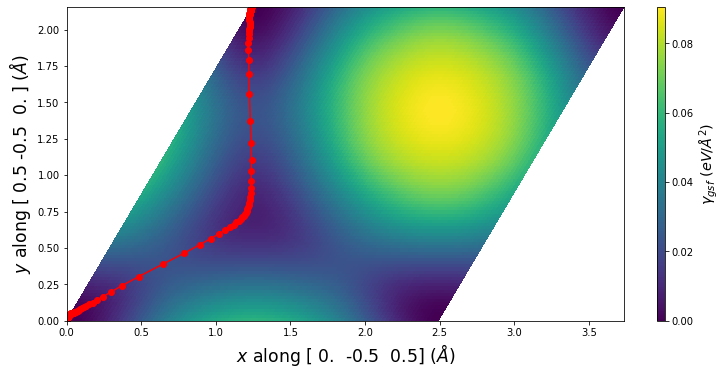

In [16]:
# Load the saved model
pnsolution = am.defect.SDVPN(model='sdvpn_run.json')

# Show that the plot is the same
pnsolution.E_gsf_surface_plot(length_unit=length_unit, energyperarea_unit=energyperarea_unit)
plt.show()